# Standard Screen Analysis

In this module go over how to analyze a standard pooled screen (e.g. viability or flow screens) using
Python. As an example, we analyze data from [Sanson et al. 2018](https://www.nature.com/articles/s41467-018-07901-8#Sec26),
comparing the activity of two tracrRNA variants using the Brunello genomewide library.

## Set up

To set up the analysis we first load all of the Python packages we need.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

Next we load the data, reading the counts matrix and annotations from a local
repository, and fetching the list of essential and non-essential genes from a remote
repository on [GitHub](https://github.com/gpp-rnd/genesets)

In [2]:
reads_df = pd.read_csv('data/Sanson2018_Brunello_reads.csv')
annotation_file = pd.read_table('data/CP0041_GRCh38_NCBI_strict_gene_20210113.chip')
essential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/essential-genes-Hart2015.txt',
                                names=['gene']).gene
nonessential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/non-essential-genes-Hart2014.txt',
                                   names=['gene']).gene

Here is what the read counts file looks like

In [3]:
reads_df

,sgRNA Sequence,pDNA_HsuTracr,A375_HsuTracr_RepA,A375_HsuTracr_RepB,pDNA_tracrV2,A375_tracrV2_RepA,A375_tracrV2_RepB,A375_tracrV2_RepC
0,AAAAAAAATCCGGACAATGG,522,729,774,247,358,1146,623
1,AAAAAAAGGATGGTGATCAA,511,1484,1393,119,1313,431,1078
2,AAAAAAATGACATTACTGCA,467,375,603,139,117,163,82
3,AAAAAAATGTCAGTCGAGTG,200,737,506,76,970,984,681
4,AAAAAACACAAGCAAGACCG,286,672,352,62,681,435,961
...,...,...,...,...,...,...,...,...
77436,TTTGTTTGGATTGCTTCAAG,514,2878,303,226,207,94,165
77437,TTTTACCTTGTTCACATGGA,828,3896,3367,262,2406,2728,2472
77438,TTTTGACTCTAATCACCGGT,588,2725,2498,151,2654,2586,3860
77439,TTTTTAATACAAGGTAATCT,503,2209,1785,105,690,424,213


And the annotations file

In [4]:
annotation_file

,Barcode Sequence,Gene Symbol,Gene ID
0,AAAAAAAATCCGGACAATGG,SLC25A24,29957
1,AAAAAAAGGATGGTGATCAA,FASTKD3,79072
2,AAAAAAATGACATTACTGCA,BCAS2,10286
3,AAAAAAATGTCAGTCGAGTG,GPR18,2841
4,AAAAAACACAAGCAAGACCG,ZNF470,388566
...,...,...,...
86978,TTTTGACTCTAATCACCGGT,INACTIVE_4T_54,INACTIVE_4T_54
86979,TTTTTAATACAAGGTAATCT,NO_SITE_940,NO_SITE_940
86980,TTTTTAATACAAGGTAATCT,INACTIVE_5T_55,INACTIVE_5T_55
86981,TTTTTCTCACCCGATGAATC,NO_SITE_941,NO_SITE_941


## Calculating log-normalized read counts

Due to differences between sequencing runs and sgRNA representation,
we log-normalize the read counts. First,
for each sgRNA we take the number of reads divided by the total number of reads in a given condition
$$\frac{\text{reads}}{\text{total reads in condition}}.$$

Since read counts tend to have a right skew, we also want to take the $\log_2$ of
these fractional abundances. Finally, since it is possible to have 0 reads and $\log_2(0)$ is undefined,
we multiply the fractional abundance by $1e6$ and add a pseudocount of 1 for our final equation

$$ \text{lognorm} = \log2\bigg(\frac{\text{reads}}{\text{total reads in condition}} \times 1e6 + 1 \bigg).$$

We can this equation as a function.

In [5]:
def lognorm(reads):
    """
    Standardize read counts by calculating reads per million,
    adding a pseudo-count of one, and taking the log2

    :param reads: numpy or pandas array
    :returns: numpy or pandas array
    """
    reads_per_million = (reads/reads.sum())*(10**6)
    lognormed_reads = np.log2(reads_per_million + 1)
    return lognormed_reads

We then apply this function to all of the read counts.

In [6]:
condition_columns = ['pDNA_HsuTracr', 'A375_HsuTracr_RepA', 'A375_HsuTracr_RepB',
                     'pDNA_tracrV2', 'A375_tracrV2_RepA', 'A375_tracrV2_RepB', 'A375_tracrV2_RepC']
lognorm_df = reads_df.copy()
lognorm_df[condition_columns] = lognorm_df[condition_columns].apply(lognorm)
lognorm_df

,sgRNA Sequence,pDNA_HsuTracr,A375_HsuTracr_RepA,A375_HsuTracr_RepB,pDNA_tracrV2,A375_tracrV2_RepA,A375_tracrV2_RepB,A375_tracrV2_RepC
0,AAAAAAAATCCGGACAATGG,4.192756,3.373924,3.521755,4.890963,2.736833,4.131168,3.454210
1,AAAAAAAGGATGGTGATCAA,4.163726,4.326828,4.312620,3.888789,4.444986,2.850820,4.188607
2,AAAAAAATGACATTACTGCA,4.041390,2.540624,3.196767,4.098830,1.511850,1.744210,1.208506
3,AAAAAAATGTCAGTCGAGTG,2.930437,3.388159,2.973599,3.295977,4.031409,3.924783,3.571378
4,AAAAAACACAAGCAAGACCG,3.388394,3.268222,2.528233,3.035039,3.558043,2.862307,4.032459
...,...,...,...,...,...,...,...,...
77436,TTTGTTTGGATTGCTTCAAG,4.171701,5.247155,2.351863,4.767286,2.096324,1.235899,1.863126
77437,TTTTACCTTGTTCACATGGA,4.828882,5.674123,5.542684,4.973232,5.288347,5.333851,5.340608
77438,TTTTGACTCTAATCACCGGT,4.355639,5.170476,5.122720,4.211587,5.426425,5.258693,5.970671
77439,TTTTTAATACAAGGTAATCT,4.142241,4.876941,4.654317,3.721145,3.575386,2.830494,2.139258


## Filtering the reference condition

Sometimes the cloning process can fail to capture an sgRNA sequence in the plasmid pool, so we remove plasmids that are not
well represented in the pool.

To decide which sgRNAs are underrepresented, we z-score the pDNA log-norms and remove
any sgRNAs with a z-score less than -3.

In [7]:
filtered_lognorms = lognorm_df.copy()
pdna_cols = ['pDNA_HsuTracr', 'pDNA_tracrV2']
z_low = -3  # minimum z-score
# Z-score the pDNA columns
z_scored_cols = []
for pdna in pdna_cols:
    z_col = pdna + '_z'
    filtered_lognorms[z_col] = (filtered_lognorms[pdna] - filtered_lognorms[pdna].mean())/filtered_lognorms[pdna].std()
    z_scored_cols.append(z_col)
# Filter by z-score
filtered_lognorms = filtered_lognorms[filtered_lognorms[z_scored_cols].min(axis = 1) > z_low]
# Drop z-scored columns
filtered_lognorms = filtered_lognorms.drop(z_scored_cols, axis=1)
filtered_lognorms

,sgRNA Sequence,pDNA_HsuTracr,A375_HsuTracr_RepA,A375_HsuTracr_RepB,pDNA_tracrV2,A375_tracrV2_RepA,A375_tracrV2_RepB,A375_tracrV2_RepC
0,AAAAAAAATCCGGACAATGG,4.192756,3.373924,3.521755,4.890963,2.736833,4.131168,3.454210
1,AAAAAAAGGATGGTGATCAA,4.163726,4.326828,4.312620,3.888789,4.444986,2.850820,4.188607
2,AAAAAAATGACATTACTGCA,4.041390,2.540624,3.196767,4.098830,1.511850,1.744210,1.208506
3,AAAAAAATGTCAGTCGAGTG,2.930437,3.388159,2.973599,3.295977,4.031409,3.924783,3.571378
4,AAAAAACACAAGCAAGACCG,3.388394,3.268222,2.528233,3.035039,3.558043,2.862307,4.032459
...,...,...,...,...,...,...,...,...
77436,TTTGTTTGGATTGCTTCAAG,4.171701,5.247155,2.351863,4.767286,2.096324,1.235899,1.863126
77437,TTTTACCTTGTTCACATGGA,4.828882,5.674123,5.542684,4.973232,5.288347,5.333851,5.340608
77438,TTTTGACTCTAATCACCGGT,4.355639,5.170476,5.122720,4.211587,5.426425,5.258693,5.970671
77439,TTTTTAATACAAGGTAATCT,4.142241,4.876941,4.654317,3.721145,3.575386,2.830494,2.139258


In [8]:
print('Filtered ' + str(lognorm_df.shape[0] - filtered_lognorms.shape[0]) + ' sgRNAs with low pDNA')

Filtered 602 sgRNAs with low pDNA


## Calculating log-fold changes

To understand how sgRNA abundance has changed over the course of the screen, we take 

$$\text{log-fold change} = \text{final time point lognorm} - \text{pDNA lognorm}.$$

We define a reference map to match final time points with their pDNA condition.

In [10]:
ref_map = {'A375_HsuTracr_RepA': 'pDNA_HsuTracr',
           'A375_HsuTracr_RepB': 'pDNA_HsuTracr',
           'A375_tracrV2_RepA': 'pDNA_tracrV2',
           'A375_tracrV2_RepB': 'pDNA_tracrV2',
           'A375_tracrV2_RepC': 'pDNA_tracrV2'}

We can then iterate over the reference map to calculate log-fold changes

In [11]:
lfc_df = filtered_lognorms.copy()
for target_col, ref_col in ref_map.items():
    # use lognorm df in case columns double as target and ref
    lfc_df[target_col] = filtered_lognorms[target_col] - filtered_lognorms[ref_col]

# Remove reference columns
for ref_col in set(ref_map.values()):
    if ref_col not in ref_map.keys(): # not a target condition as well
        lfc_df = lfc_df.drop(ref_col, axis=1)
lfc_df

,sgRNA Sequence,A375_HsuTracr_RepA,A375_HsuTracr_RepB,A375_tracrV2_RepA,A375_tracrV2_RepB,A375_tracrV2_RepC
0,AAAAAAAATCCGGACAATGG,-0.818831,-0.671000,-2.154130,-0.759795,-1.436753
1,AAAAAAAGGATGGTGATCAA,0.163102,0.148894,0.556197,-1.037969,0.299818
2,AAAAAAATGACATTACTGCA,-1.500766,-0.844622,-2.586980,-2.354621,-2.890325
3,AAAAAAATGTCAGTCGAGTG,0.457721,0.043161,0.735432,0.628806,0.275401
4,AAAAAACACAAGCAAGACCG,-0.120172,-0.860161,0.523004,-0.172731,0.997420
...,...,...,...,...,...,...
77436,TTTGTTTGGATTGCTTCAAG,1.075454,-1.819838,-2.670962,-3.531387,-2.904160
77437,TTTTACCTTGTTCACATGGA,0.845240,0.713801,0.315115,0.360619,0.367376
77438,TTTTGACTCTAATCACCGGT,0.814837,0.767081,1.214838,1.047106,1.759083
77439,TTTTTAATACAAGGTAATCT,0.734700,0.512076,-0.145759,-0.890650,-1.581887


## Combining samples

When we calculate the Pearson correlation between the log-fold change from all conditions, we see that replicates group nicely together.

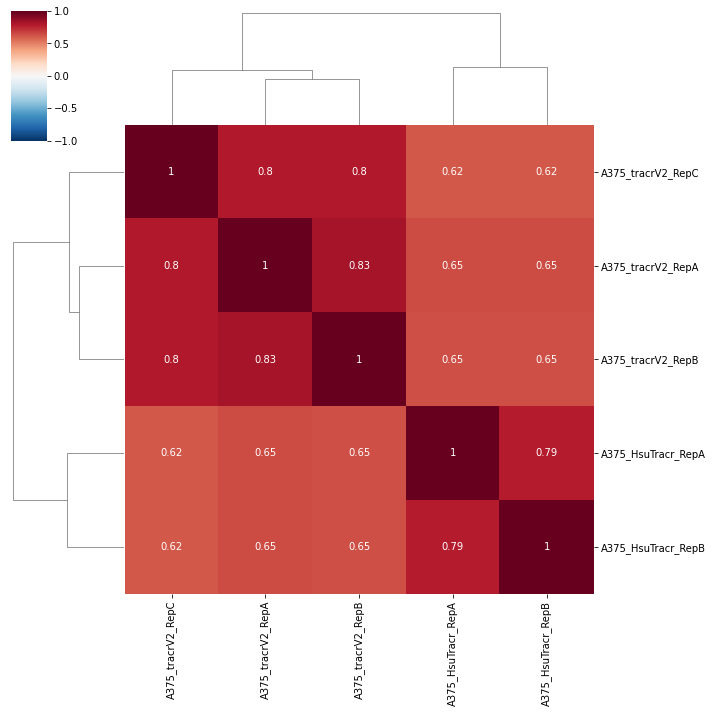

In [12]:
lfc_correlations = lfc_df.corr()
sns.clustermap(lfc_correlations, cmap='RdBu_r',
               vmin=-1, vmax=1, annot=True)

Due to this strong correlation, we average log-fold changes
across replicates. To do so, we create a condition map between replicates and their
condition name.

In [15]:
condition_map = {'A375_HsuTracr_RepA': 'A375_HsuTracr',
                 'A375_HsuTracr_RepB': 'A375_HsuTracr',
                 'A375_tracrV2_RepA': 'A375_tracrV2',
                 'A375_tracrV2_RepB': 'A375_tracrV2',
                 'A375_tracrV2_RepC': 'A375_tracrV2'}

We melt the log-fold change dataframe to its [long form](https://en.wikipedia.org/wiki/Tidy_data) for easier data manipulation

In [13]:
long_lfcs = (lfc_df.melt(id_vars='sgRNA Sequence',
                         var_name='condition', value_name='lfc'))
long_lfcs

,sgRNA Sequence,condition,lfc
0,AAAAAAAATCCGGACAATGG,A375_HsuTracr_RepA,-0.818831
1,AAAAAAAGGATGGTGATCAA,A375_HsuTracr_RepA,0.163102
2,AAAAAAATGACATTACTGCA,A375_HsuTracr_RepA,-1.500766
3,AAAAAAATGTCAGTCGAGTG,A375_HsuTracr_RepA,0.457721
4,AAAAAACACAAGCAAGACCG,A375_HsuTracr_RepA,-0.120172
...,...,...,...
384190,TTTGTTTGGATTGCTTCAAG,A375_tracrV2_RepC,-2.904160
384191,TTTTACCTTGTTCACATGGA,A375_tracrV2_RepC,0.367376
384192,TTTTGACTCTAATCACCGGT,A375_tracrV2_RepC,1.759083
384193,TTTTTAATACAAGGTAATCT,A375_tracrV2_RepC,-1.581887


We remap the condition names and average log-fold changes by replicate.

In [16]:
long_lfcs['condition'] = long_lfcs['condition'].map(condition_map)
avg_lfcs = (long_lfcs.groupby(['sgRNA Sequence', 'condition'])
            .agg(avg_lfc = ('lfc', 'mean'),
                 n_obs = ('lfc', 'count'))
            .reset_index())
avg_lfcs

,sgRNA Sequence,condition,avg_lfc,n_obs
0,AAAAAAAATCCGGACAATGG,A375_HsuTracr,-0.744916,2
1,AAAAAAAATCCGGACAATGG,A375_tracrV2,-1.450226,3
2,AAAAAAAGGATGGTGATCAA,A375_HsuTracr,0.155998,2
3,AAAAAAAGGATGGTGATCAA,A375_tracrV2,-0.060651,3
4,AAAAAAATGACATTACTGCA,A375_HsuTracr,-1.172694,2
...,...,...,...,...
153673,TTTTGACTCTAATCACCGGT,A375_tracrV2,1.340342,3
153674,TTTTTAATACAAGGTAATCT,A375_HsuTracr,0.623388,2
153675,TTTTTAATACAAGGTAATCT,A375_tracrV2,-0.872765,3
153676,TTTTTCTCACCCGATGAATC,A375_HsuTracr,0.914082,2


## Merging with annotations

To interpret the log-fold changes we merge with our annotations file,
mapping sgRNAs to genes.

In [17]:
annotated_sgrna_lfcs = (avg_lfcs.merge(annotation_file.rename({'Barcode Sequence': 'sgRNA Sequence'}, axis=1),
                                       how='inner',
                                       on='sgRNA Sequence'))
annotated_sgrna_lfcs

,sgRNA Sequence,condition,avg_lfc,n_obs,Gene Symbol,Gene ID
0,AAAAAAAATCCGGACAATGG,A375_HsuTracr,-0.744916,2,SLC25A24,29957
1,AAAAAAAATCCGGACAATGG,A375_tracrV2,-1.450226,3,SLC25A24,29957
2,AAAAAAAGGATGGTGATCAA,A375_HsuTracr,0.155998,2,FASTKD3,79072
3,AAAAAAAGGATGGTGATCAA,A375_tracrV2,-0.060651,3,FASTKD3,79072
4,AAAAAAATGACATTACTGCA,A375_HsuTracr,-1.172694,2,BCAS2,10286
...,...,...,...,...,...,...
172567,TTTTTAATACAAGGTAATCT,A375_tracrV2,-0.872765,3,INACTIVE_5T_55,INACTIVE_5T_55
172568,TTTTTCTCACCCGATGAATC,A375_HsuTracr,0.914082,2,NO_SITE_941,NO_SITE_941
172569,TTTTTCTCACCCGATGAATC,A375_HsuTracr,0.914082,2,INACTIVE_5T_56,INACTIVE_5T_56
172570,TTTTTCTCACCCGATGAATC,A375_tracrV2,-0.019545,3,NO_SITE_941,NO_SITE_941


## Calculating sgRNA level z-scores

To evaluate the effect size of knockout, we scale
log-fold changes by the NO_SITE controls

In [18]:
control_sgrna_lfcs = (annotated_sgrna_lfcs[(annotated_sgrna_lfcs['Gene Symbol']
                                            .str.contains('NO_SITE'))]
                      .reset_index(drop=True))
control_sgrna_lfcs

,sgRNA Sequence,condition,avg_lfc,n_obs,Gene Symbol,Gene ID
0,AAAAAGCTTCCGCCTGATGG,A375_HsuTracr,0.717411,2,NO_SITE_1,NO_SITE_1
1,AAAAAGCTTCCGCCTGATGG,A375_tracrV2,1.358684,3,NO_SITE_1,NO_SITE_1
2,AAAACAGGACGATGTGCGGC,A375_HsuTracr,0.562531,2,NO_SITE_2,NO_SITE_2
3,AAAACAGGACGATGTGCGGC,A375_tracrV2,0.525780,3,NO_SITE_2,NO_SITE_2
4,AAAACATCGACCGAAAGCGT,A375_HsuTracr,0.208693,2,NO_SITE_3,NO_SITE_3
...,...,...,...,...,...,...
1855,TTTTGACTCTAATCACCGGT,A375_tracrV2,1.340342,3,NO_SITE_939,NO_SITE_939
1856,TTTTTAATACAAGGTAATCT,A375_HsuTracr,0.623388,2,NO_SITE_940,NO_SITE_940
1857,TTTTTAATACAAGGTAATCT,A375_tracrV2,-0.872765,3,NO_SITE_940,NO_SITE_940
1858,TTTTTCTCACCCGATGAATC,A375_HsuTracr,0.914082,2,NO_SITE_941,NO_SITE_941


We caluclate the mean and standard deviation of these controls to get z-scores.

In [21]:
control_sgrna_stats = (control_sgrna_lfcs.groupby('condition')
                       .agg(neg_ctl_mean = ('avg_lfc', 'mean'),
                            neg_ctl_sd = ('avg_lfc', 'std'))
                       .reset_index())
control_sgrna_stats

,condition,neg_ctl_mean,neg_ctl_sd
0,A375_HsuTracr,0.685959,0.259441
1,A375_tracrV2,0.793282,0.605216


In [22]:
zscored_sgrna_lfcs = annotated_sgrna_lfcs.copy()
zscored_sgrna_lfcs = (zscored_sgrna_lfcs.merge(control_sgrna_stats,
                                               how='inner', on='condition'))
zscored_sgrna_lfcs['z_scored_avg_lfc'] = ((zscored_sgrna_lfcs['avg_lfc'] - zscored_sgrna_lfcs['neg_ctl_mean'])/
                                          zscored_sgrna_lfcs['neg_ctl_sd'])
zscored_sgrna_lfcs = zscored_sgrna_lfcs.drop(['neg_ctl_sd', 'neg_ctl_mean'], axis=1)
zscored_sgrna_lfcs

,sgRNA Sequence,condition,avg_lfc,n_obs,Gene Symbol,Gene ID,z_scored_avg_lfc
0,AAAAAAAATCCGGACAATGG,A375_HsuTracr,-0.744916,2,SLC25A24,29957,-5.515215
1,AAAAAAAGGATGGTGATCAA,A375_HsuTracr,0.155998,2,FASTKD3,79072,-2.042700
2,AAAAAAATGACATTACTGCA,A375_HsuTracr,-1.172694,2,BCAS2,10286,-7.164058
3,AAAAAAATGTCAGTCGAGTG,A375_HsuTracr,0.250441,2,GPR18,2841,-1.678674
4,AAAAAACACAAGCAAGACCG,A375_HsuTracr,-0.490166,2,ZNF470,388566,-4.533298
...,...,...,...,...,...,...,...
172567,TTTTGACTCTAATCACCGGT,A375_tracrV2,1.340342,3,INACTIVE_4T_54,INACTIVE_4T_54,0.903908
172568,TTTTTAATACAAGGTAATCT,A375_tracrV2,-0.872765,3,NO_SITE_940,NO_SITE_940,-2.752813
172569,TTTTTAATACAAGGTAATCT,A375_tracrV2,-0.872765,3,INACTIVE_5T_55,INACTIVE_5T_55,-2.752813
172570,TTTTTCTCACCCGATGAATC,A375_tracrV2,-0.019545,3,NO_SITE_941,NO_SITE_941,-1.343035


## Calculating gene-level z-scores and statistics

To combine z-scores at the gene level, we sum the sgRNA z-scores and divide by the
standard deviation of the number of sgRNAs

In [23]:
zscored_gene_lfcs = (zscored_sgrna_lfcs.groupby(['Gene Symbol', 'condition'])
                     .agg(z_scored_lfc_sum = ('z_scored_avg_lfc', 'sum'),
                          n_sgrnas = ('avg_lfc', 'count'))
                     .reset_index())
zscored_gene_lfcs['z_scored_avg_lfc'] = (zscored_gene_lfcs['z_scored_lfc_sum']/np.sqrt(zscored_gene_lfcs['n_sgrnas']))
zscored_gene_lfcs = zscored_gene_lfcs.drop('z_scored_lfc_sum', axis=1)
zscored_gene_lfcs

,Gene Symbol,condition,n_sgrnas,z_scored_avg_lfc
0,A1BG,A375_HsuTracr,3,-5.144452
1,A1BG,A375_tracrV2,3,-1.640905
2,A1CF,A375_HsuTracr,4,-1.431112
3,A1CF,A375_tracrV2,4,-2.083231
4,A2M,A375_HsuTracr,4,-3.062964
...,...,...,...,...
43247,ZYX,A375_tracrV2,4,-1.200102
43248,ZZEF1,A375_HsuTracr,4,-4.484510
43249,ZZEF1,A375_tracrV2,4,-1.772401
43250,ZZZ3,A375_HsuTracr,4,-11.016867


We calculate p-values from the z-score by using a reference normal distribution from `scipy`.

In [24]:
zscored_gene_lfcs['p_value'] = (zscored_gene_lfcs.groupby('condition')
                                ['z_scored_avg_lfc']
                                .transform(lambda x: scipy.stats.norm.sf(abs(x))*2))
zscored_gene_lfcs

,Gene Symbol,condition,n_sgrnas,z_scored_avg_lfc,p_value
0,A1BG,A375_HsuTracr,3,-5.144452,2.683029e-07
1,A1BG,A375_tracrV2,3,-1.640905,1.008171e-01
2,A1CF,A375_HsuTracr,4,-1.431112,1.523982e-01
3,A1CF,A375_tracrV2,4,-2.083231,3.723021e-02
4,A2M,A375_HsuTracr,4,-3.062964,2.191568e-03
...,...,...,...,...,...
43247,ZYX,A375_tracrV2,4,-1.200102,2.300997e-01
43248,ZZEF1,A375_HsuTracr,4,-4.484510,7.308168e-06
43249,ZZEF1,A375_tracrV2,4,-1.772401,7.632802e-02
43250,ZZZ3,A375_HsuTracr,4,-11.016867,3.168960e-28


We then correct for multiple hypothesis testing using the [Benjamini-Hochberg](http://www.biostathandbook.com/multiplecomparisons.html) procedure.

In [25]:
zscored_gene_lfcs['FDR'] = (zscored_gene_lfcs.groupby('condition')
                            ['p_value']
                            .transform(lambda x: multipletests(x, method='fdr_bh')[1]))
zscored_gene_lfcs

,Gene Symbol,condition,n_sgrnas,z_scored_avg_lfc,p_value,FDR
0,A1BG,A375_HsuTracr,3,-5.144452,2.683029e-07,5.043740e-07
1,A1BG,A375_tracrV2,3,-1.640905,1.008171e-01,1.268189e-01
2,A1CF,A375_HsuTracr,4,-1.431112,1.523982e-01,1.629549e-01
3,A1CF,A375_tracrV2,4,-2.083231,3.723021e-02,5.312355e-02
4,A2M,A375_HsuTracr,4,-3.062964,2.191568e-03,2.672390e-03
...,...,...,...,...,...,...
43247,ZYX,A375_tracrV2,4,-1.200102,2.300997e-01,2.642524e-01
43248,ZZEF1,A375_HsuTracr,4,-4.484510,7.308168e-06,1.161679e-05
43249,ZZEF1,A375_tracrV2,4,-1.772401,7.632802e-02,9.919890e-02
43250,ZZZ3,A375_HsuTracr,4,-11.016867,3.168960e-28,1.982411e-27


Now we can generate a volcano plot from the z-scores and FDR values

/Users/pdeweird/.conda/envs/computational-resources/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


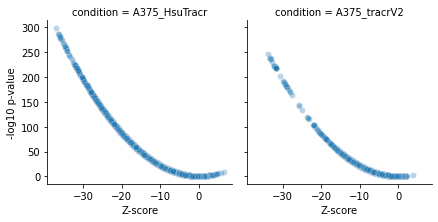

In [26]:
zscored_gene_lfcs['-log(FDR)'] = -np.log10(zscored_gene_lfcs['FDR'])
g = sns.FacetGrid(data=zscored_gene_lfcs,
                  col='condition')
g.map_dataframe(sns.scatterplot, x='z_scored_avg_lfc', y='-log(FDR)',
                alpha=0.3)
sns.despine()
g.set_axis_labels(x_var='Z-score',
                  y_var='-log10 p-value')

## ROC between essential and nonessential genes

To compare the two tracrRNAs we calculate [ROC curves](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
using sgRNAs targeting essential genes as positive controls and
sgRNAs targeting nonessential genes as negative controls. Here we calculate
ROCs at the sgRNA level, but they can also be calculated at the gene level.

In [27]:
roc_df =  zscored_sgrna_lfcs.copy()
roc_df['pos_ctl'] = roc_df['Gene Symbol'].isin(essential_genes)
roc_df['neg_ctl'] = roc_df['Gene Symbol'].isin(nonessential_genes)
roc_df = (roc_df[roc_df['pos_ctl'] | roc_df['neg_ctl']]
          .reset_index(drop=True))
tpr_fpr_df_list = []
roc_auc_list = []
for group, df in roc_df.groupby('condition'):
    fpr, tpr, treshold = roc_curve(df['pos_ctl'], -df['z_scored_avg_lfc'])
    group_tpr_fpr_df = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': treshold})
    group_tpr_fpr_df['condition'] = group
    tpr_fpr_df_list.append(group_tpr_fpr_df)
    roc_auc = auc(fpr, tpr)
    roc_auc_list.append({'condition': group, 'ROC-AUC': roc_auc})
sgrna_roc_aucs = pd.DataFrame(roc_auc_list)
sgrna_tpr_fpr_df = (pd.concat(tpr_fpr_df_list).reset_index(drop=True))
sgrna_roc_aucs

,condition,ROC-AUC
0,A375_HsuTracr,0.913521
1,A375_tracrV2,0.898707


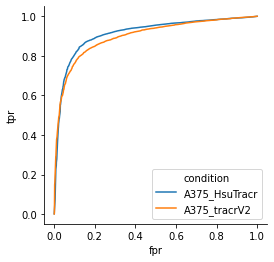

In [28]:
plt.subplots(figsize=(4, 4))
sns.lineplot(data=sgrna_tpr_fpr_df, x='fpr',
             y='tpr', hue='condition', ci=None)
sns.despine()

We can see from the ROC curves that Brunello with the Hsu tracr
is better than Brunello with tracr-v2.

## Next steps

All of the analyses
written here are included as functions in the
python package [poola](https://github.com/gpp-rnd/poola). We recommend
that you use poola once you understand the code in this notebook.
